## Feature Extraction toolbox

In [2]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
import mat73
from scipy.io import loadmat, savemat
import mne
#conda install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session
import random

In [3]:
def prep_clean_soz(SOZ_ch_labels):
    """ 
    function will clean the SOZ labels for each patient.
    input: SOZ_ch_labels from load pt data function. 
    output: list of cleaned names for each patient --> essentially adds '-CAR' to the end of each label.
    """
    clean_soz_labels = []
    for i in range(len(SOZ_ch_labels)):
        labels = SOZ_ch_labels.iloc[i]
        labels_to_list = [x for x in labels]
        if type(labels_to_list[0]) == str:
            labels_squish = labels_to_list[0].replace(" ","")
            labels_split = labels_squish.split(',')
            clean_labels_per_pt = [x+'-CAR' for x in labels_split]
            clean_soz_labels.append(clean_labels_per_pt)
        else: 
            clean_soz_labels.append('SOZ not defined')

    return clean_soz_labels

def load_pt(ptname, data_directory):
    """
    input: ptname, a string containing the name of the patient you want to load. example: 'HUP100'
    output: object: spike ---- contains: List of 1000 random spikes: spike.select   and their subsequent:
    values: spike.values, chlabels: spike.chlabels, fs: spike.fs, soz channels: spike.soz
    """        

    val = mat73.loadmat(data_directory + '/values/values_{}.mat'.format(ptname))
    val2 = val['values_all']
    select_spikes = loadmat(data_directory + '/randi/randi_{}.mat'.format(ptname))
    select_spikes = select_spikes['select_spikes']
    ch_labels = loadmat(data_directory + '/chlabels/chlabels_{}.mat'.format(ptname))
    ch_labels = ch_labels['ch_labels_all']
    fs_all = loadmat(data_directory + '/fs/fs_{}.mat'.format(ptname))
    fs_all = fs_all['fs_all']
    SOZ_chlabels = pd.read_csv(data_directory + '/pt_data/SOZ_channels.csv')
    pt_all = pd.read_csv('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database/pt_data/ptname_all.csv')
    ptname = ("'{}'".format(pt_name))
    whichpt = pt_all.index[pt_all['ptname'] == ptname].tolist()
    clean_SOZ_chlabels = prep_clean_soz(SOZ_chlabels)
    
    class spike:
        values = val2
        select=select_spikes
        chlabels = ch_labels
        fs = fs_all
        soz = clean_SOZ_chlabels[whichpt[0]]

    return spike

In [4]:
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP100'
spike = load_pt(pt_name,data_directory)

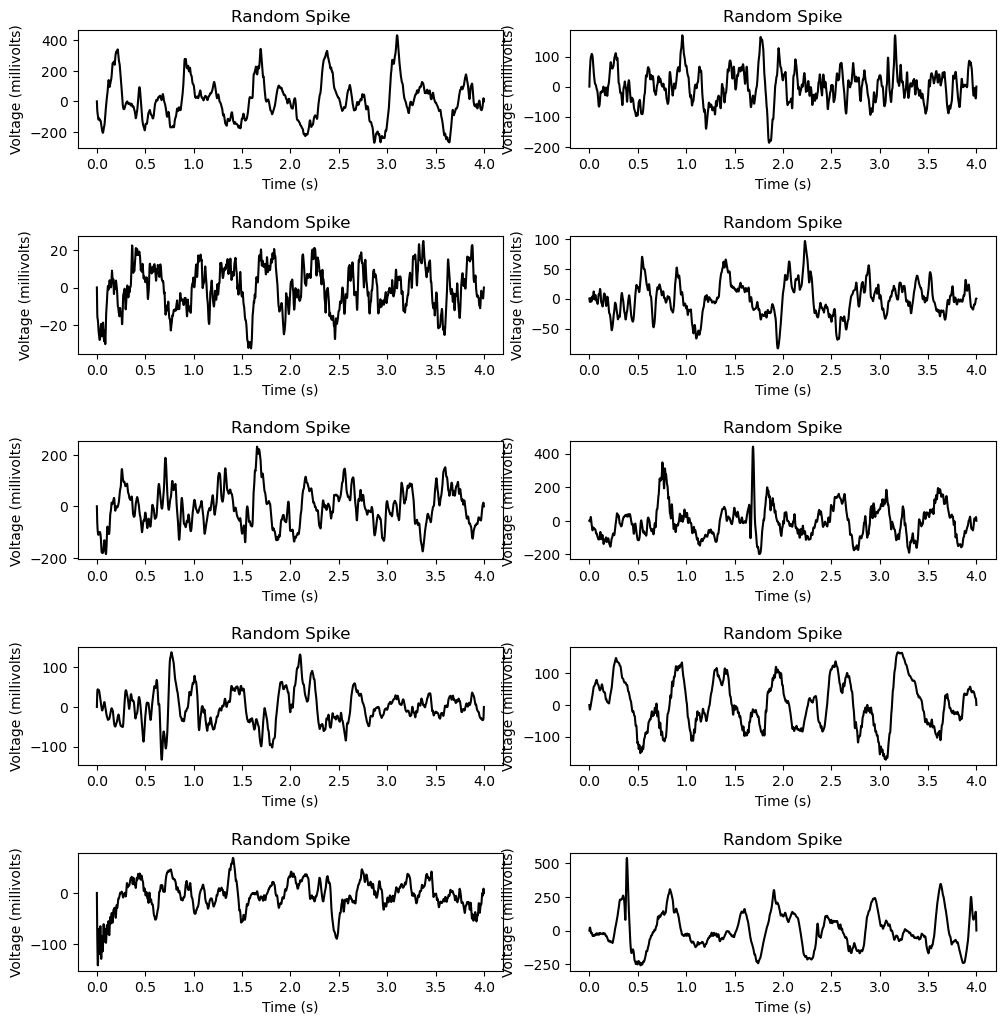

In [5]:
#function that takes random value matrix and plots
def plot_rand_spikes(values):
    plot_idx = range(5)
    fig, axs = plt.subplots(len(plot_idx), 2, figsize=(10,10))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.74)

    time = np.linspace(0,4,2001)
    for i in plot_idx:
        
        choice1 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice2 = random.choice(np.transpose(values[choice1])) #picks what spike to plot in run_time
        
        choice3 = random.choice(range(len(values))) #picks from what run_time to pull from
        choice4 = random.choice(np.transpose(values[choice3])) #picks what spike to plot in run_time
        
        axs[i,0].plot(time, choice2, 'k') #plot nerve data - unfiltered
        axs[i,0].set_ylabel("Voltage (millivolts)")
        axs[i,0].set_xlabel("Time (s)")
        axs[i,0].set_title("Random Spike")
        
        axs[i,1].plot(time, choice4,'k') #plot new axs. 
        axs[i,1].set_ylabel("Voltage (millivolts)")
        axs[i,1].set_xlabel("Time (s)")
        axs[i,1].set_title("Random Spike")

    return

plot_rand_spikes(spike.values)

933


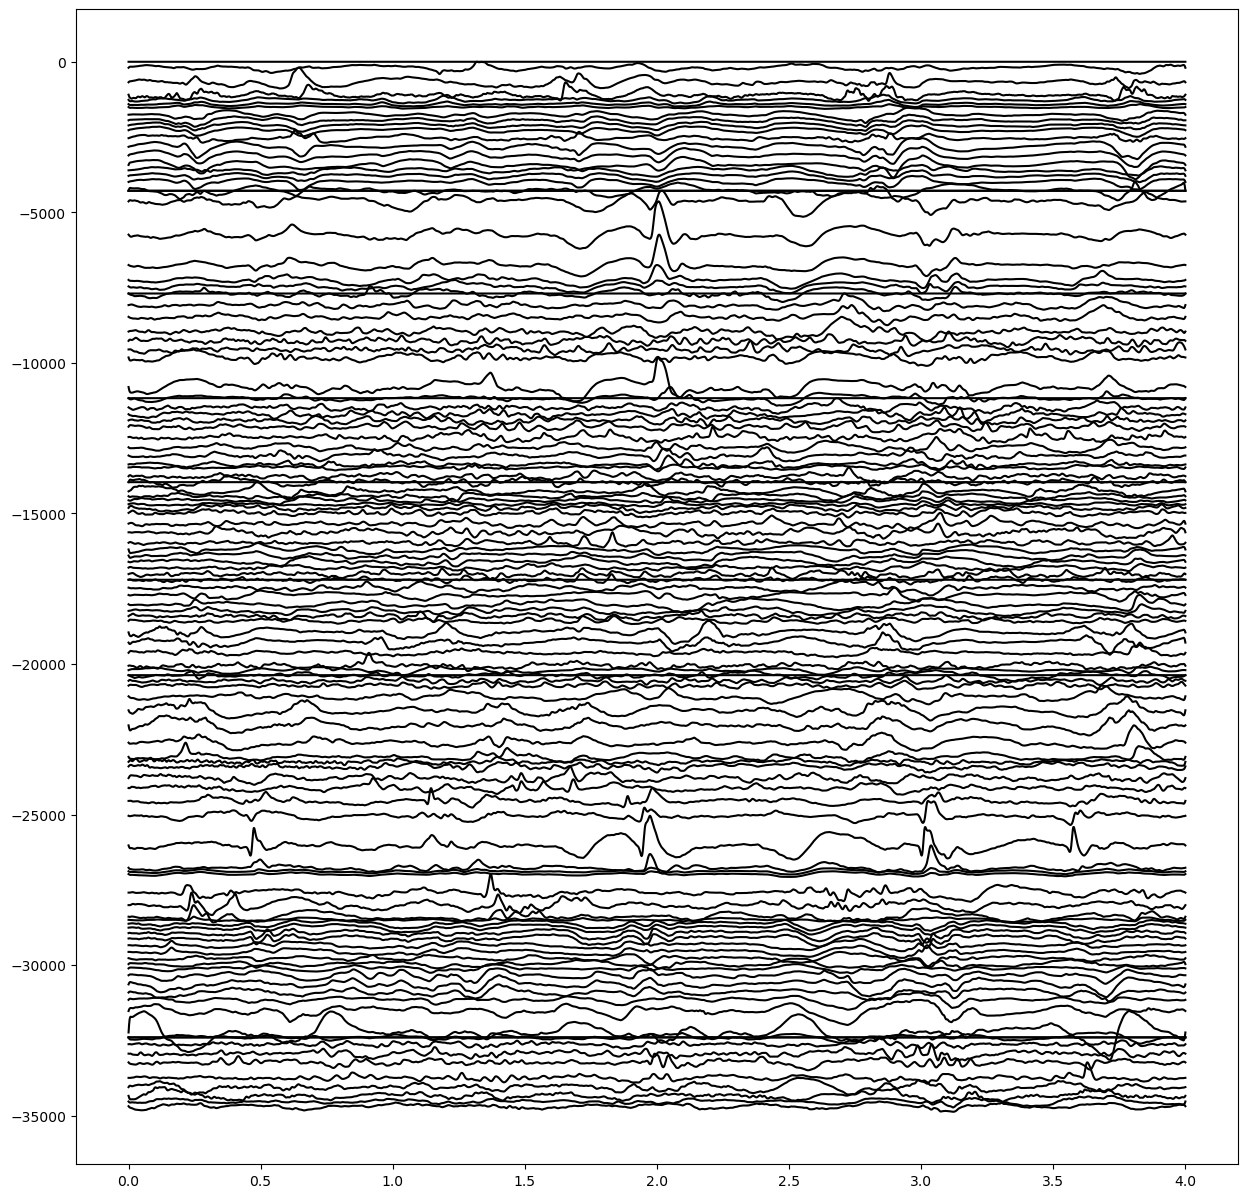

In [6]:
#function that takes random matrix, and plots down the channels
def plot_rand_eeg(values):
    set = random.choice(range(len(values)))
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
    
    return set


print(plot_rand_eeg(spike.values))

304


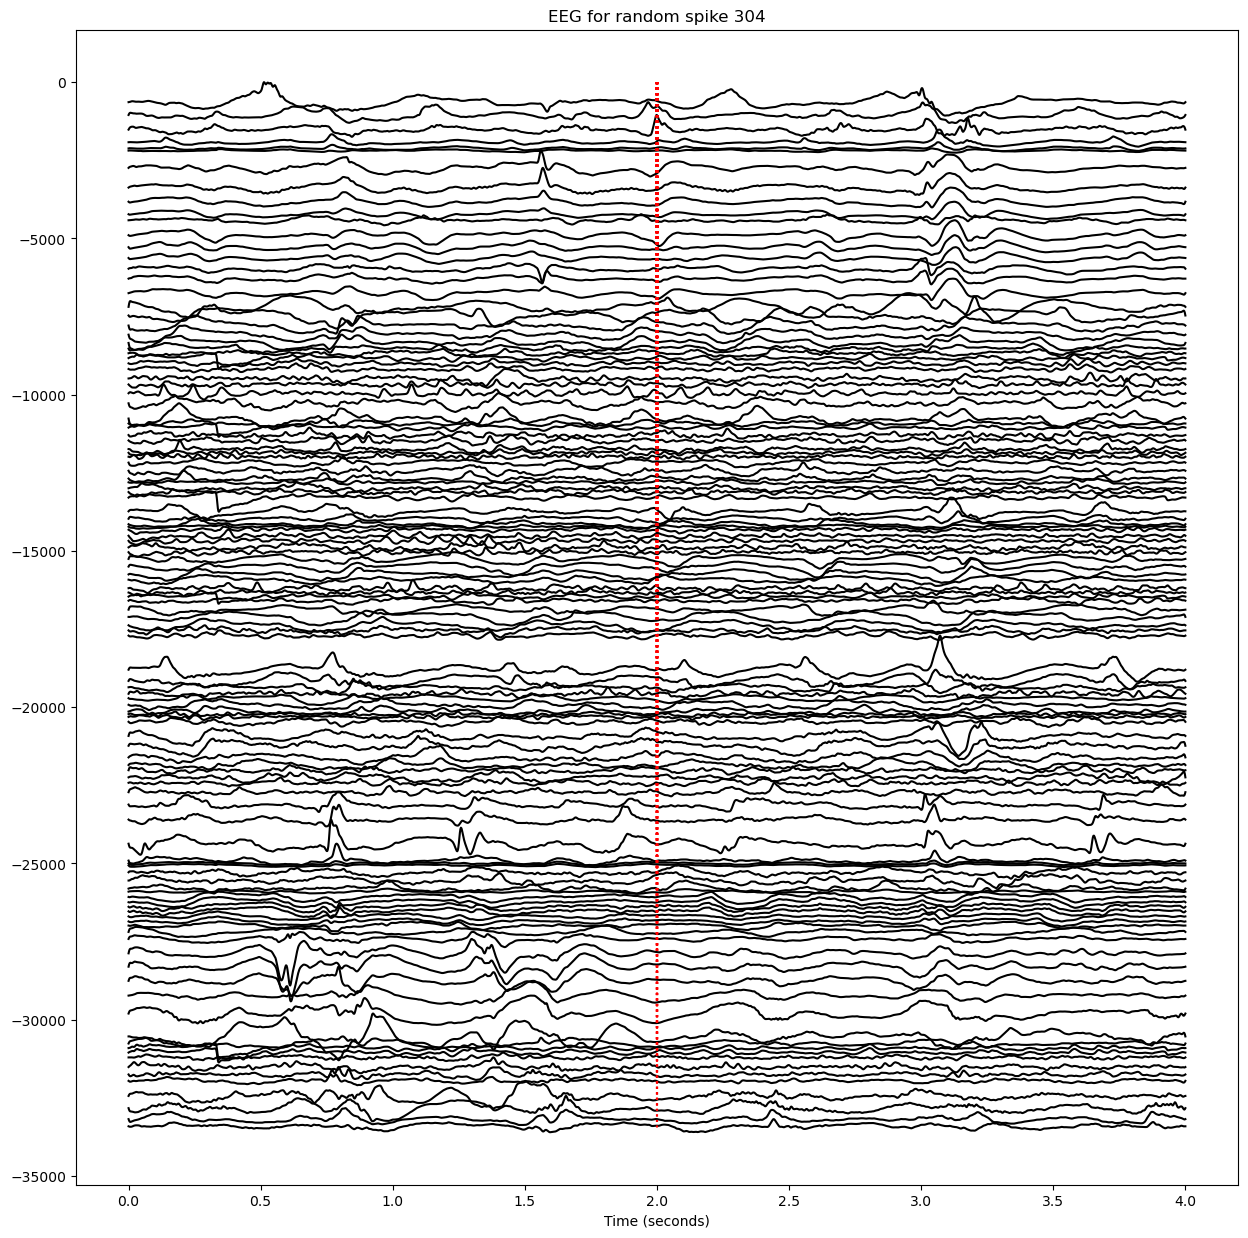

In [7]:
#function that takes random matrix, and plots down the channels
def plot_eeg(values, set):
    values_for_all = (values[set])
    time = np.linspace(0,4,np.size(values_for_all,0))
    offset = 0
    plt.figure(figsize = (15,15))

    for i in range(np.size(values_for_all,1)):
        values_per_ch = values_for_all.transpose()
        plot_values = values_per_ch[i]
        val = plot_values.flatten()
        if math.isnan(np.mean(val)) == True:
            continue
        #val = [0 if math.isnan(x) else x for x in val]
        offset = offset + np.max(val)
        plt.plot(time, val - offset,'k')
        plt.title('EEG for random spike {}'.format(set))
        plt.xlabel('Time (seconds)')
        plt.vlines(2,0,-offset-100,colors='r',linestyles='dotted')
    
    return set

print(plot_eeg(spike.values,304))

In [8]:
# line length
def LL(x):
    return np.sum(np.absolute(np.ediff1d(x)))

# energy
def E(x):
    return np.sum(x ** 2)

#RMS
def RMS(x):
    return np.sqrt(np.mean(x**2))

# area
def A(x):
    return np.sum(np.absolute(x))

# spectral amp
def spectral_amplitude(x):
    x_fft = np.fft.fft(x)
    return np.mean(x_fft)

def mean_amplitude_freq(X, fs, lF, uF):
    time_step = 1/fs
    ps = np.abs(np.fft.fft(X)) ** 2
    freqs = np.fft.fftfreq(X.size, time_step)
    mask = np.logical_and(freqs >= lF, freqs <= uF )
    avgValue = ps[mask].mean()
    return avgValue

# number of crossings (zero) - not in
def ZX(x):
    x_demean = x - np.mean(x)
    num_crossings = 0
    for i in range(1, len(x)):
        fromAbove = False
        fromBelow = False
        if x_demean[i - 1] > 0 and x_demean[i] < 0:
            fromAbove = True
        if x_demean[i - 1] < 0 and x_demean[i] > 0:
            fromBelow = True

        if fromAbove or fromBelow:
            num_crossings += 1
    return num_crossings

def MEAN(x):
    return np.mean(x)

def bandpower(x, fs, fmin, fmax):
    f, Pxx = sig.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [9]:
#function to apply feature extraction to a single matrix
def create_feat_list(values):
    feats = []
    for val in values:
        feat_per_spike = []
        val_t = val.transpose()
        for list in val_t:
            list = [0 if math.isnan(x) else x for x in list]
            maxes = np.max(np.absolute(list[750:1251])) #calculate max values around peak
            linelen = LL(list)
            area = A(list)
            feat_per_spike.append([maxes,linelen, area])
        feats.append(feat_per_spike)
    
    return feats

In [10]:
feats = create_feat_list(spike.values)

In [11]:
print(np.shape(feats))

(1000, 125, 3)


In [12]:
def find_spike_ch(select_spikes,values):
    #this function will find the values for the spiking channel.
    #should return a 1000 x #ofsamples matrix

    select_spikes_ch = []
    for spikes in select_spikes:
        ch = spikes[1]
        ch = int(ch)-1
        select_spikes_ch.append(ch)
    
    spike_value_all = []
    for i in range(np.size(values,0)):
        val = values[i]
        val_t = val.transpose()
        spike_value = val_t[select_spikes_ch[i]]
        spike_value_all.append(spike_value)

    return select_spikes_ch, spike_value_all #list of spiking channels, list of values for each spiking channel.

In [13]:
select_spikes_ch, spike_value_all = find_spike_ch(spike.select,spike.values)

In [14]:
print(np.shape(spike_value_all))
print(np.shape(random.choice(spike_value_all)))

(1000, 2001)
(2001,)


In [15]:
#function that takes random value matrix and plots
def plot_rand_onlyspikes(values,select_spikes):
    select_spikes_ch, spike_value_all = find_spike_ch(select_spikes,values)

    plot_idx = range(5)
    #fig, axs = plt.subplots(len(plot_idx), 2, figsize=(10,10))
    #fig.tight_layout()
    #fig.subplots_adjust(hspace=0.74)

    time = np.linspace(0,4,2001)
    columns = 5
    rows = 10
    fig, ax_array = plt.subplots(rows,columns, squeeze=True,figsize=(40,40),dpi=80)
    fig.subplots_adjust(hspace=0.74)
    for i, ax_row in enumerate(ax_array):
        for j, axes in enumerate(ax_row):
            choice=random.choice(spike_value_all)
            axes.plot(time, choice, 'k')
            axes.set_title("Random Spike")
            axes.set_ylabel("Voltage (millivolts)")
            axes.set_xlabel('Time (s)')

    for i in plot_idx:
        continue
        
        choice1 = (random.choice(spike_value_all)) #picks from what run_time to pull from
        
        choice3 = (random.choice(spike_value_all)) #picks from what run_time to pull from
        
        axs[i,0].plot(time, (choice1), 'k') #plot nerve data - unfiltered
        axs[i,0].set_ylabel("Voltage (millivolts)")
        axs[i,0].set_xlabel("Time (s)")
        axs[i,0].set_title("Random Spike")
        
        axs[i,1].plot(time, (choice3),'k') #plot new axs. 
        axs[i,1].set_ylabel("Voltage (millivolts)")
        axs[i,1].set_xlabel("Time (s)")
        axs[i,1].set_title("Random Spike")

    return fig

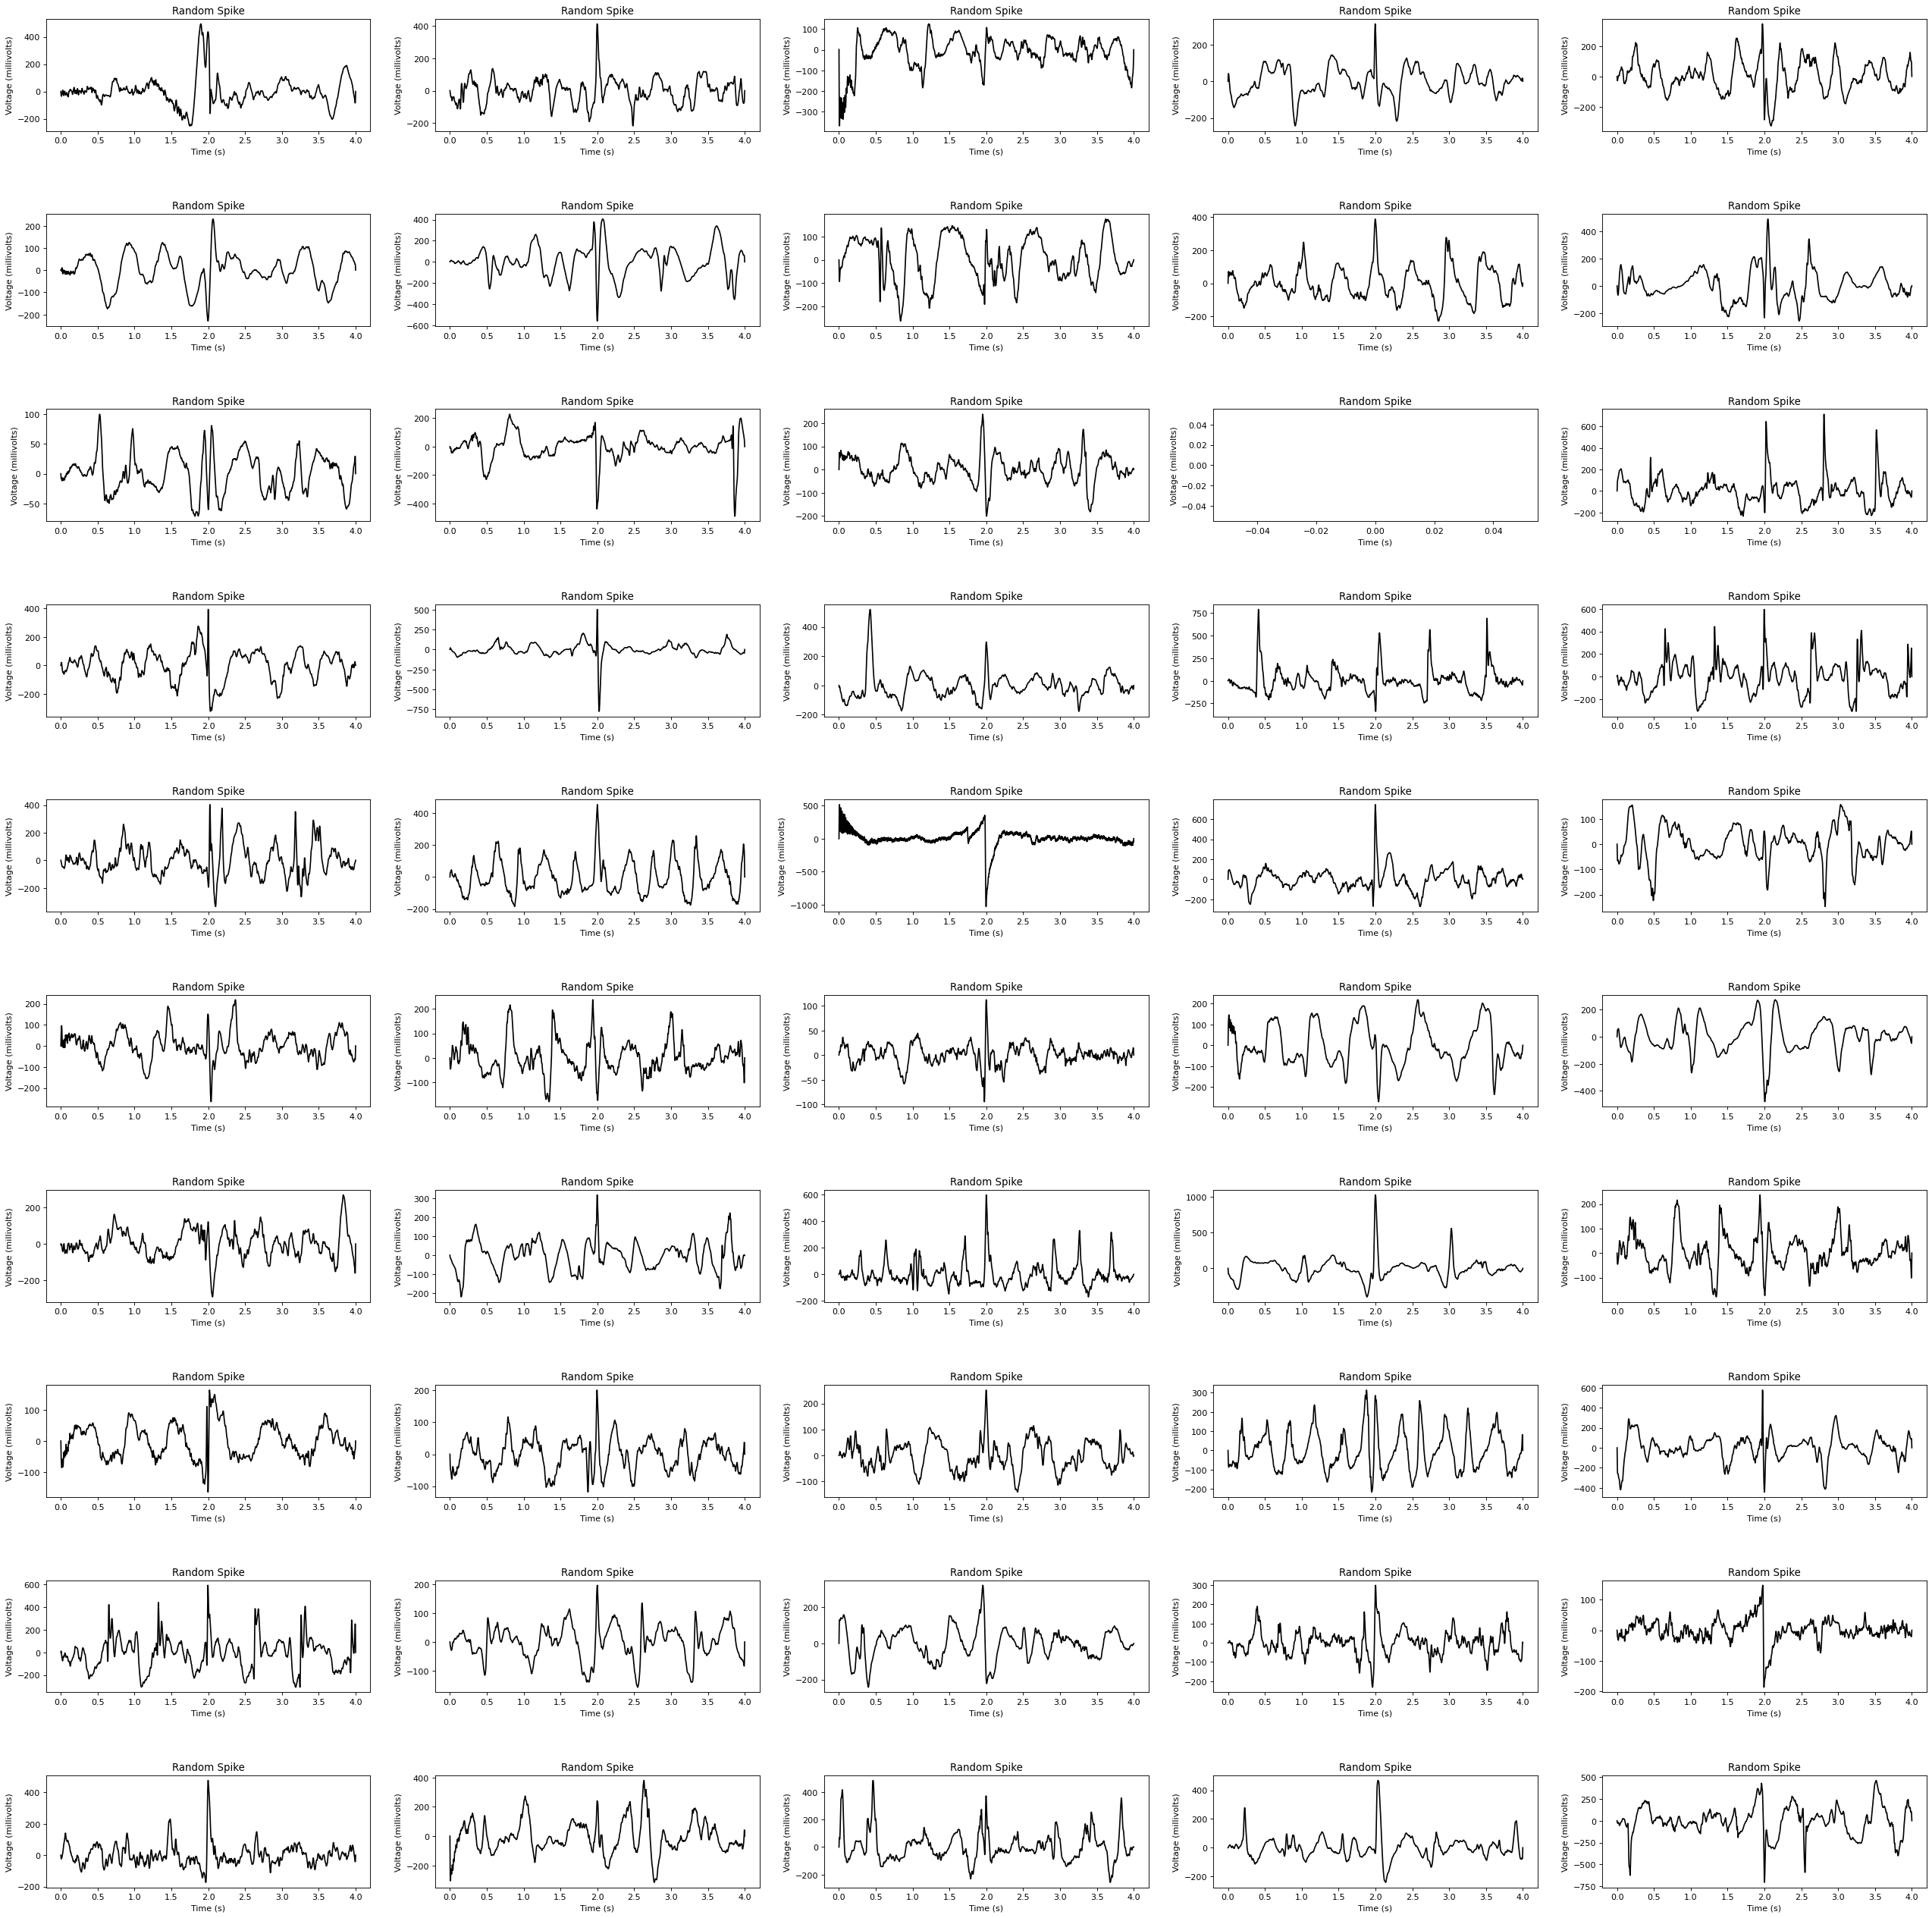

In [16]:
fig3 = plot_rand_onlyspikes(spike.values,spike.select)

In [17]:
#dataframe with all the ptnames and their subsequent whichPts
pt_all = pd.read_csv('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Patient/pt_database/pt_data/ptname_all.csv')
display(pt_all)
x = (pt_all['ptname'].iloc[1])
ptname2 = ("'{}'".format(pt_name))
yo = pt_all.index[pt_all['ptname'] == ptname2].tolist()
yo2 = pt_all.iloc[yo]
print(yo)
print('---------------------------')
print(yo2)

whichPts    ptname
0           1  'HUP100'
1           2  'HUP101'
2           3  'HUP102'
3           4  'HUP105'
4           5  'HUP106'
..        ...       ...
114       115  'HUP219'
115       116  'HUP221'
116       117  'HUP223'
117       118  'HUP224'
118       119  'HUP225'

[119 rows x 2 columns]

[0]
---------------------------
   whichPts    ptname
0         1  'HUP100'


In [18]:
def hifreq_ch_spike(select_spikes):
    """ 
    function to find the frequency of spiking for a unique channel
    input: 1000 random spike file (randi)
    output: 2x1 list containing the unique channels[0] and the frequency in which they are spiking [1]
    """

    spiking_ch = [] #create list of spiking channels from spike.select (1000 random spikes)
    for spike in select_spikes:
        spiking_ch.append(spike[1])

    uniq_chs = np.unique(spiking_ch) #generate unique channels

    counts=[] #find the frequency
    for ch in uniq_chs:
        x = spiking_ch.count(ch)
        counts.append(x)

    total = 0 #sanity check - the frequency of ch's should add up to 1000
    for ele in range(0, len(counts)):
        total = total + counts[ele]
    if total != 1000:
        print('not working correct')

    spiking_chs = [int(x) for x in spiking_ch]

    return [uniq_chs, counts], spiking_chs

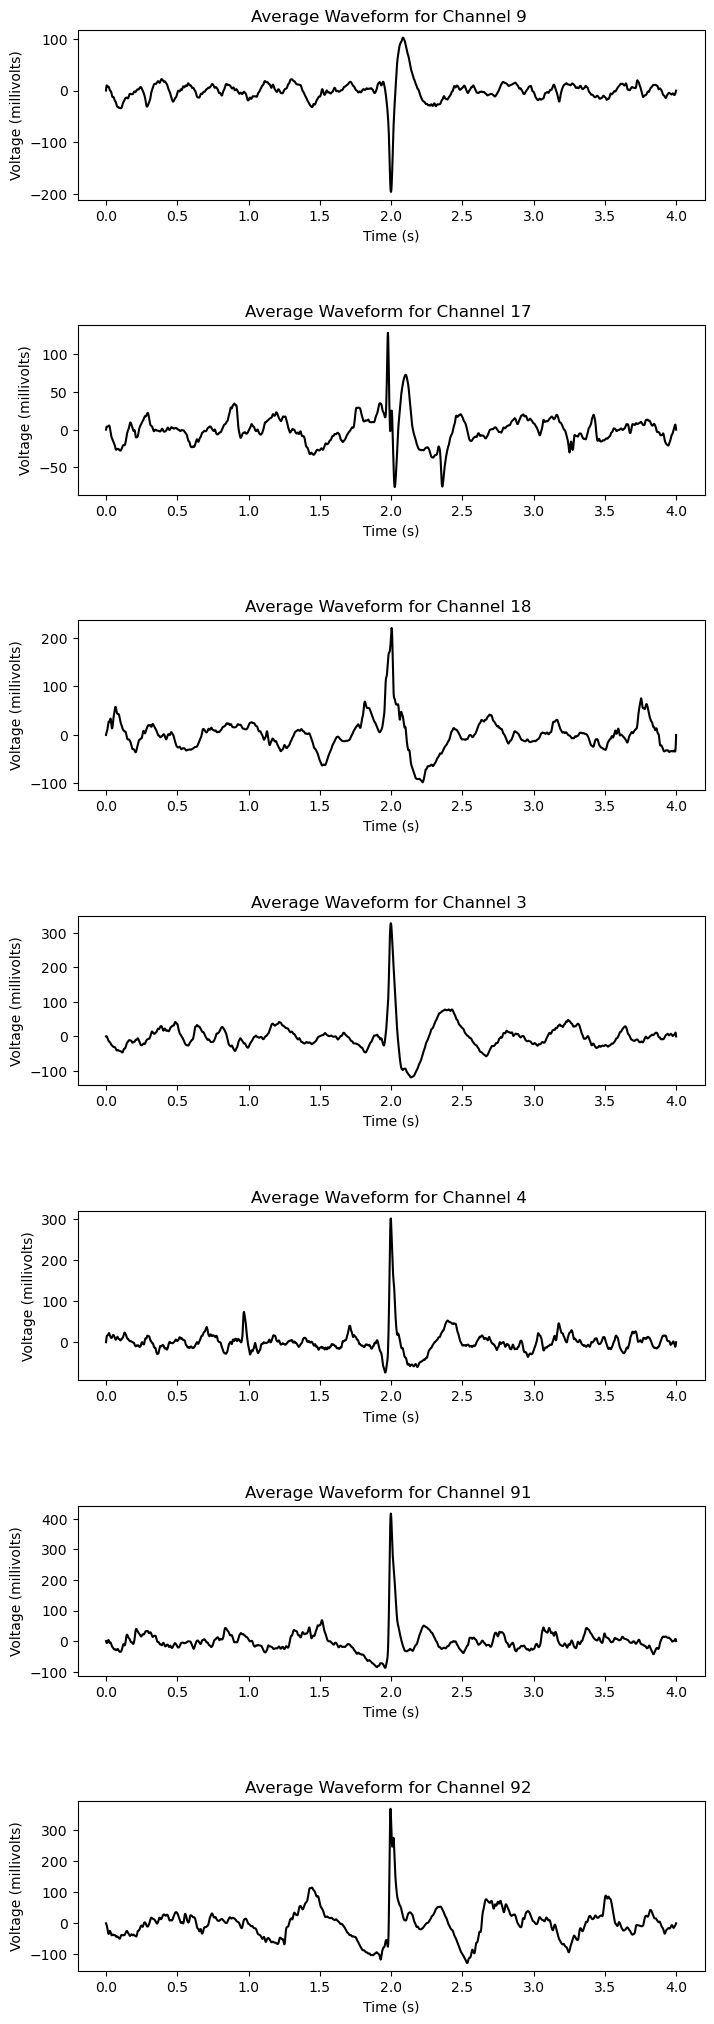

In [19]:
#work for the function: average_waveform_hifreq

counts, chs = hifreq_ch_spike(spike.select)
sorted_counts = np.sort(counts[1])
x = sorted_counts[-1]
y = sorted_counts[-5:-1]
high_freq_count = np.append(y,x) #finds the highest spiking counts

loc_high_counts = []
for i in range(len(high_freq_count)):
    loc_high_counts.append((np.where(counts[1] == high_freq_count[i])[0]))
loc_high_counts = (np.concatenate(loc_high_counts)) #find where the highest spiking counts are located.

high_chs = counts[0][loc_high_counts] #find the channel number of the highest spiking count.

#index of the channel with highest freq, from the 1000 spikes
idx_of_all_chs = []
for ch in high_chs:
    idx_of_all_chs.append(np.where(chs == ch)[0])
#idx_of_all_chs = np.concatenate(idx_of_all_chs) 

#find the average waveform for each spike.chlabels
waveforms = []
for i in range(len(high_chs)):
    spike_at_ch = []
    for spike_x in idx_of_all_chs[i]:
        spike_xs = (spike.values[spike_x])
        spike_fix = spike_xs[:,int(high_chs[i])-1]
        spike_at_ch.append(spike_fix)
    waveforms.append(spike_at_ch)

avg_waveforms = []
for waves in waveforms:
    avg_waveforms.append(np.mean(waves,axis=0))

fig, axs = plt.subplots(len(avg_waveforms), 1, figsize=(7,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.74)
time = np.linspace(0,4,2001)
for i in range(len(waveforms)):
    axs[i].plot(time, avg_waveforms[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {} ".format(int(high_chs[i])))

In [20]:
def average_waveform_hifreq(spike_select, spike_values):
    """
    This function serves to find channel which created the most spikes and plot their average waveform
    input: 1000 random spikes file and the corresponding values
    output: figure with the average waveform, and a list with the average waveform of the top 5 highest frequent channels (if theres ties, it adds more channels)
    """

    counts, chs = hifreq_ch_spike(spike_select)
    sorted_counts = np.sort(counts[1])
    x = sorted_counts[-1]
    y = sorted_counts[-5:-1]
    high_freq_count = np.append(y,x) #finds the highest spiking counts

    loc_high_counts = []
    for i in range(len(high_freq_count)):
        loc_high_counts.append((np.where(counts[1] == high_freq_count[i])[0]))
    loc_high_counts = (np.concatenate(loc_high_counts)) #find where the highest spiking counts are located.

    high_chs = counts[0][loc_high_counts] #find the channel number of the highest spiking count.

    #index of the channel with highest freq, from the 1000 spikes
    idx_of_all_chs = []
    for ch in high_chs:
        idx_of_all_chs.append(np.where(chs == ch)[0])
    #idx_of_all_chs = np.concatenate(idx_of_all_chs) 

    #find the average waveform for each spike.chlabels
    waveforms = []
    for i in range(len(high_chs)):
        spike_at_ch = []
        for spike_x in idx_of_all_chs[i]:
            spike_xs = (spike_values[spike_x])
            spike_fix = spike_xs[:,int(high_chs[i])-1]
            spike_at_ch.append(spike_fix)
        waveforms.append(spike_at_ch)

    #calculate the average
    avg_waveforms = []
    for waves in waveforms:
        avg_waveforms.append(np.mean(waves,axis=0))

    #plot average waveform
    fig, axs = plt.subplots(len(avg_waveforms), 1, figsize=(7,15))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.74)
    time = np.linspace(0,4,2001)
    for i in range(len(waveforms)):
        axs[i].plot(time, avg_waveforms[i], 'k') #plot nerve data - unfiltered
        axs[i].set_ylabel("Voltage (millivolts)")
        axs[i].set_xlabel("Time (s)")
        axs[i].set_title("Average Waveform for Channel {}, Freq = {}/1000".format(int(high_chs[i]), len(waveforms[i])))

    return fig, avg_waveforms


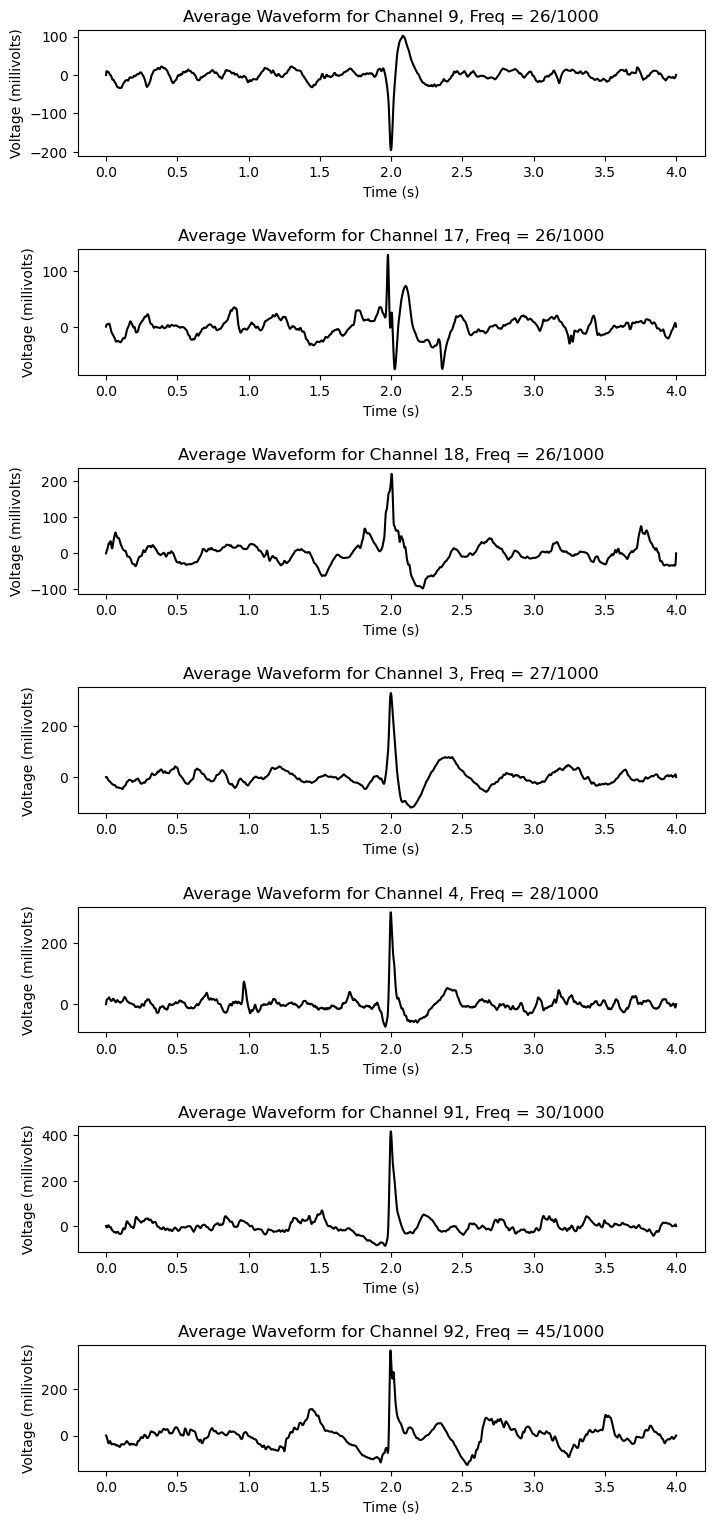

In [21]:
fig, avg_hi_waveforms = average_waveform_hifreq(spike.select, spike.values)

In [22]:
#load patient 100
data_directory = '/Users/carlosaguila/Downloads'
pt_name = 'HUP101'
spike = load_pt(pt_name,data_directory)

In [23]:
spike.soz

['LPF2-CAR',
 'LPF3-CAR',
 'ROF7-CAR',
 'ROF8-CAR',
 'APD1-CAR',
 'APD2-CAR',
 'APD3-CAR',
 'APD4-CAR',
 'PPD1-CAR',
 'PPD2-CAR',
 'PPD3-CAR',
 'PPD4-CAR']

In [24]:
np.shape(spike.chlabels[0][600])

(120, 1)

In [25]:
SOZ_find = np.where(spike.chlabels[0][600] == spike.soz)[0]

In [26]:
SOZ_find #these are indices 0 based, add 1
SOZ_channels = [x+1 for x in SOZ_find]
print(SOZ_find)
print(SOZ_channels)

[  4   5   6   7  55  56  80  81  82  83 106 107]
[5, 6, 7, 8, 56, 57, 81, 82, 83, 84, 107, 108]


In [27]:
spike.chlabels[0][600][SOZ_find]


array([[array(['APD1-CAR'], dtype='<U8')],
       [array(['APD2-CAR'], dtype='<U8')],
       [array(['APD3-CAR'], dtype='<U8')],
       [array(['APD4-CAR'], dtype='<U8')],
       [array(['LPF2-CAR'], dtype='<U8')],
       [array(['LPF3-CAR'], dtype='<U8')],
       [array(['PPD1-CAR'], dtype='<U8')],
       [array(['PPD2-CAR'], dtype='<U8')],
       [array(['PPD3-CAR'], dtype='<U8')],
       [array(['PPD4-CAR'], dtype='<U8')],
       [array(['ROF7-CAR'], dtype='<U8')],
       [array(['ROF8-CAR'], dtype='<U8')]], dtype=object)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


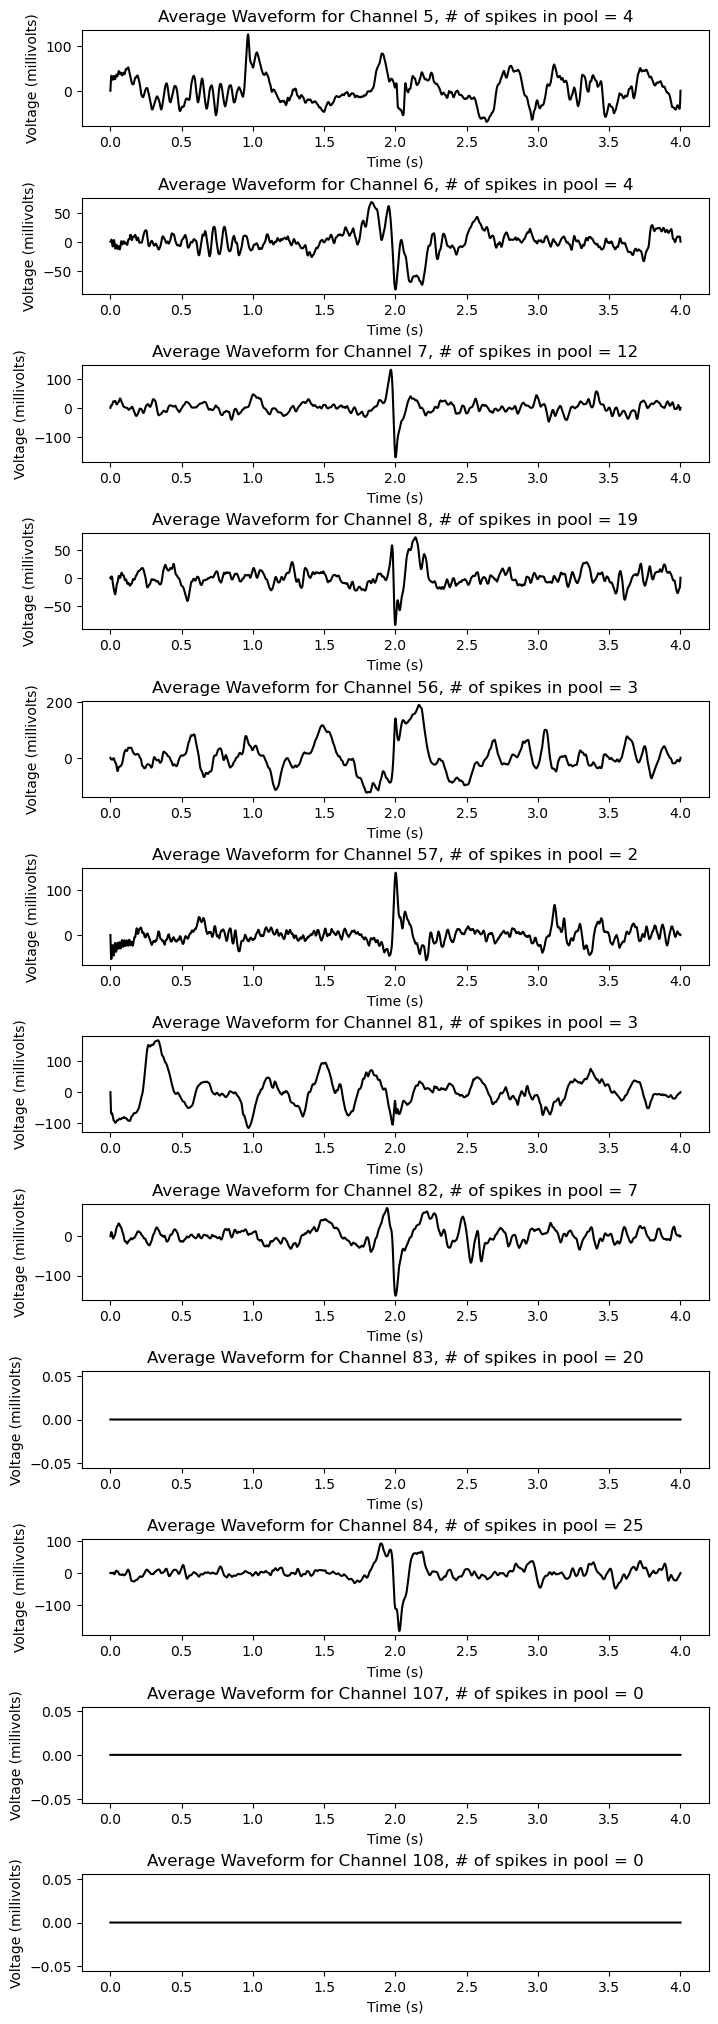

In [28]:
SOZ_spikes = []
for soz in SOZ_channels:
    x = np.where(spike.select[:,1] == soz)[0]
    SOZ_spikes.append(x)
#print((SOZ_spikes))
#print(SOZ_channels)

soz_waveforms = []
for i in range(len(SOZ_spikes)):
    soz_wave = []
    for j in SOZ_spikes[i]:
        soz_spikex = spike.values[j]
        soz_spike_fix = soz_spikex[:,int(SOZ_channels[i])-1]
        soz_wave.append(soz_spike_fix)
    soz_waveforms.append(soz_wave)

avg_sozwaveform = []
for sozwave in soz_waveforms:
    avg_sozwaveform.append(np.mean(sozwave,axis=0))

for i in range(len(avg_sozwaveform)):
    if np.shape(avg_sozwaveform[i]) == ():
        avg_sozwaveform[i] = np.zeros([2001,1])
    elif np.isnan(avg_sozwaveform[i][0]):
        avg_sozwaveform[i] = np.zeros([2001,1])

#plot average waveform
fig, axs = plt.subplots(len(avg_sozwaveform), 1, figsize=(7,20))
fig.tight_layout()
fig.subplots_adjust(hspace=0.74)
time = np.linspace(0,4,2001)
for i in range(len(soz_waveforms)):
    axs[i].plot(time, avg_sozwaveform[i], 'k') #plot nerve data - unfiltered
    axs[i].set_ylabel("Voltage (millivolts)")
    axs[i].set_xlabel("Time (s)")
    axs[i].set_title("Average Waveform for Channel {}, # of spikes in pool = {}".format(int(SOZ_channels[i]), len(SOZ_spikes[i])))

In [30]:
(spike.chlabels[0][501][2][0][0])

'AFD3-CAR'

In [31]:
chlabels = []
for label in spike.chlabels[0][500]:
    chlabels.append(label[0][0])

In [39]:
x = 'HEL10'
y = []
for yo in x:
    print(yo)
    if yo.isdigit() == False:
        y.append(yo)

print(y)


H
E
L
1
0
['H', 'E', 'L']
